# Weekly Sales Prediction for Walmart Stores

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import date
import math
warnings.filterwarnings('ignore')
np.random.seed(7)

In [ ]:
print("Loading datasets...")
# Load datasets
train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

# Merge data
data = pd.merge(train, features, on=["Store", "Date"], how="left")
data = pd.merge(data, stores, on=["Store"], how="left")

# Convert 'Date' to datetime
data["Date"] = pd.to_datetime(data["Date"])
data.sort_values("Date", inplace=True)

# Drop markdown columns with too many missing values
data = data.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

print("Data shape:", data.shape)
print("Data columns:", data.columns.tolist())
print(data.head())

Loading datasets...
Data shape: (421570, 12)
Data columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size']
        Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  \
0           1     1 2010-02-05      24924.50        False        42.31   
277665     29     5 2010-02-05      15552.08        False        24.36   
277808     29     6 2010-02-05       3200.22        False        24.36   
277951     29     7 2010-02-05      10820.05        False        24.36   
278094     29     8 2010-02-05      20055.64        False        24.36   

        Fuel_Price         CPI  Unemployment  IsHoliday_y Type    Size  
0            2.572  211.096358         8.106        False    A  151315  
277665       2.788  131.527903        10.064        False    B   93638  
277808       2.788  131.527903        10.064        False    B   93638  
277951       2.788  131.527903        10.064        False    B  

# 1. Data Preprocessing ⚙️

In [ ]:
# Check time intervals - verify chronological order and equidistant timestamps
data['delta'] = data['Date'] - data['Date'].shift(1)
print("Time Delta Statistics:")
print(data['delta'].value_counts().head())

Time Delta Statistics:
delta
0 days    421427
7 days       142
Name: count, dtype: int64


In [ ]:
# Handle missing values
print("\nMissing Values Before:")
print(data.isna().sum())

# Fill missing values with appropriate method
# Using interpolation for numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if data[col].isna().sum() > 0:
        # Using interpolation for better results
        data[col] = data[col].interpolate()

print("\nMissing Values After:")
print(data.isna().sum())


Missing Values Before:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday_x     0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
IsHoliday_y     0
Type            0
Size            0
delta           1
dtype: int64

Missing Values After:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday_x     0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
IsHoliday_y     0
Type            0
Size            0
delta           1
dtype: int64


# 2. Feature Engineering 🔧

In [ ]:
# Create time-based features
data['year'] = pd.DatetimeIndex(data['Date']).year
data['month'] = pd.DatetimeIndex(data['Date']).month
data['day'] = pd.DatetimeIndex(data['Date']).day
data['day_of_year'] = pd.DatetimeIndex(data['Date']).dayofyear
# Get week of year as integers without creating a DatetimeIndex
data['week_of_year'] = data['Date'].dt.isocalendar().week
data['quarter'] = pd.DatetimeIndex(data['Date']).quarter
data['season'] = data['month'] % 12 // 3 + 1

# Encoding cyclical features
# Month has cyclical nature
month_in_year = 12
data['month_sin'] = np.sin(2*np.pi*data['month']/month_in_year)
data['month_cos'] = np.cos(2*np.pi*data['month']/month_in_year)

# Week has cyclical nature
week_in_year = 52
data['week_sin'] = np.sin(2*np.pi*data['week_of_year']/week_in_year)
data['week_cos'] = np.cos(2*np.pi*data['week_of_year']/week_in_year)

print("Feature Engineered Data:")
print(data[['Date', 'year', 'month', 'month_sin', 'month_cos',
           'week_of_year', 'week_sin', 'week_cos', 'season']].head())

Feature Engineered Data:
             Date  year  month  month_sin  month_cos  week_of_year  week_sin  \
0      2010-02-05  2010      2   0.866025        0.5             5  0.568065   
277665 2010-02-05  2010      2   0.866025        0.5             5  0.568065   
277808 2010-02-05  2010      2   0.866025        0.5             5  0.568065   
277951 2010-02-05  2010      2   0.866025        0.5             5  0.568065   
278094 2010-02-05  2010      2   0.866025        0.5             5  0.568065   

        week_cos  season  
0       0.822984       1  
277665  0.822984       1  
277808  0.822984       1  
277951  0.822984       1  
278094  0.822984       1  


# 3. Exploratory Data Analysis 📊

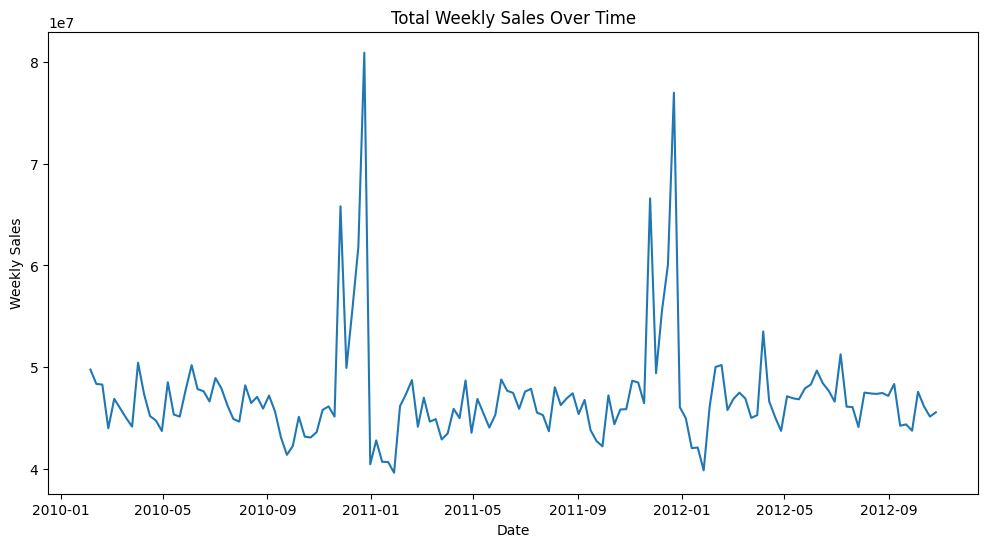

In [ ]:
# Time series of weekly sales over time
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="Weekly_Sales", data=data.groupby("Date")["Weekly_Sales"].sum().reset_index())
plt.title("Total Weekly Sales Over Time")
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()


Starting comprehensive EDA...



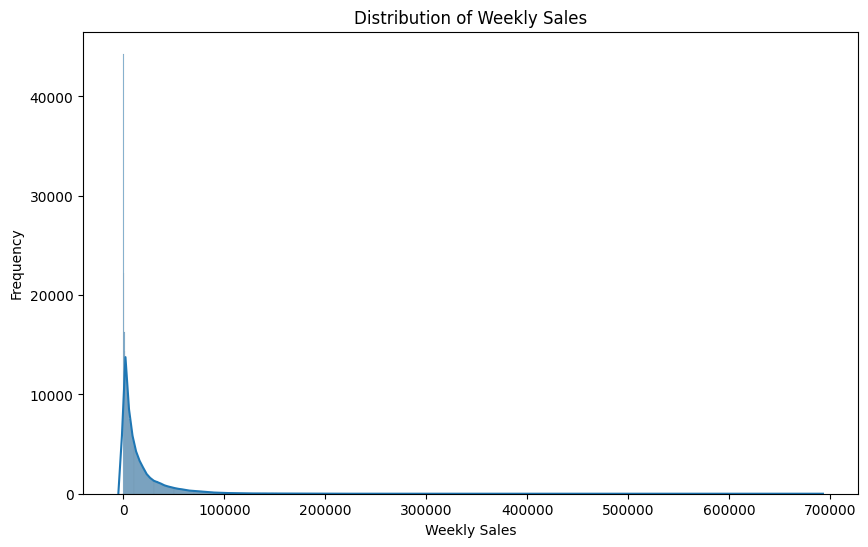

In [ ]:
print("\nStarting comprehensive EDA...\n")

# Distribution of weekly sales
plt.figure(figsize=(10, 6))
sns.histplot(data['Weekly_Sales'], kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

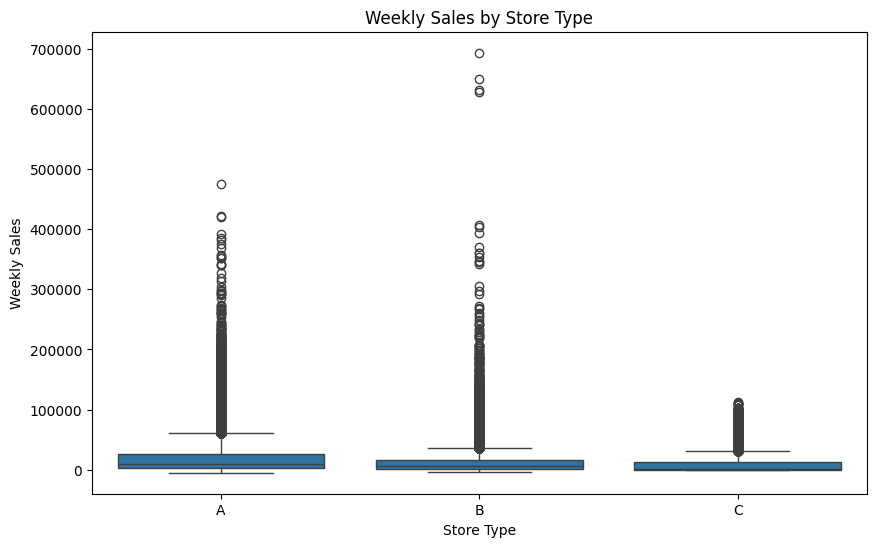

In [ ]:
# Box plot of weekly sales by store type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Weekly_Sales', data=data)
plt.title('Weekly Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Weekly Sales')
plt.show()

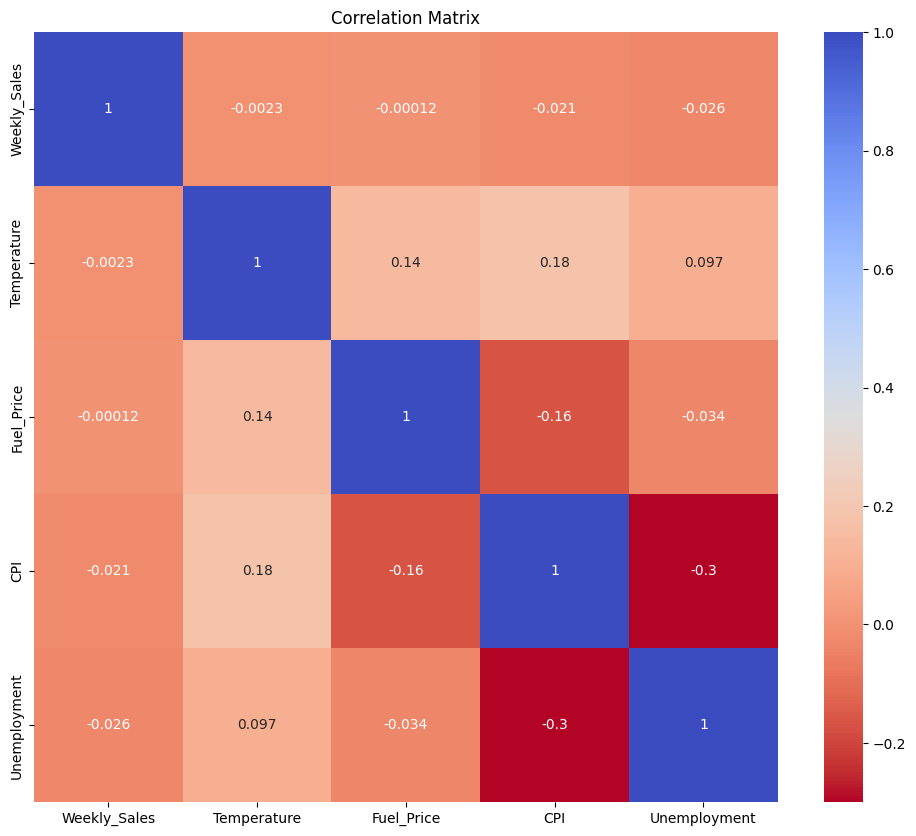

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
sns.heatmap(data[correlation_columns].corr(), annot=True, cmap='coolwarm_r')
plt.title("Correlation Matrix")
plt.show()

# 4. Stationarity Analysis

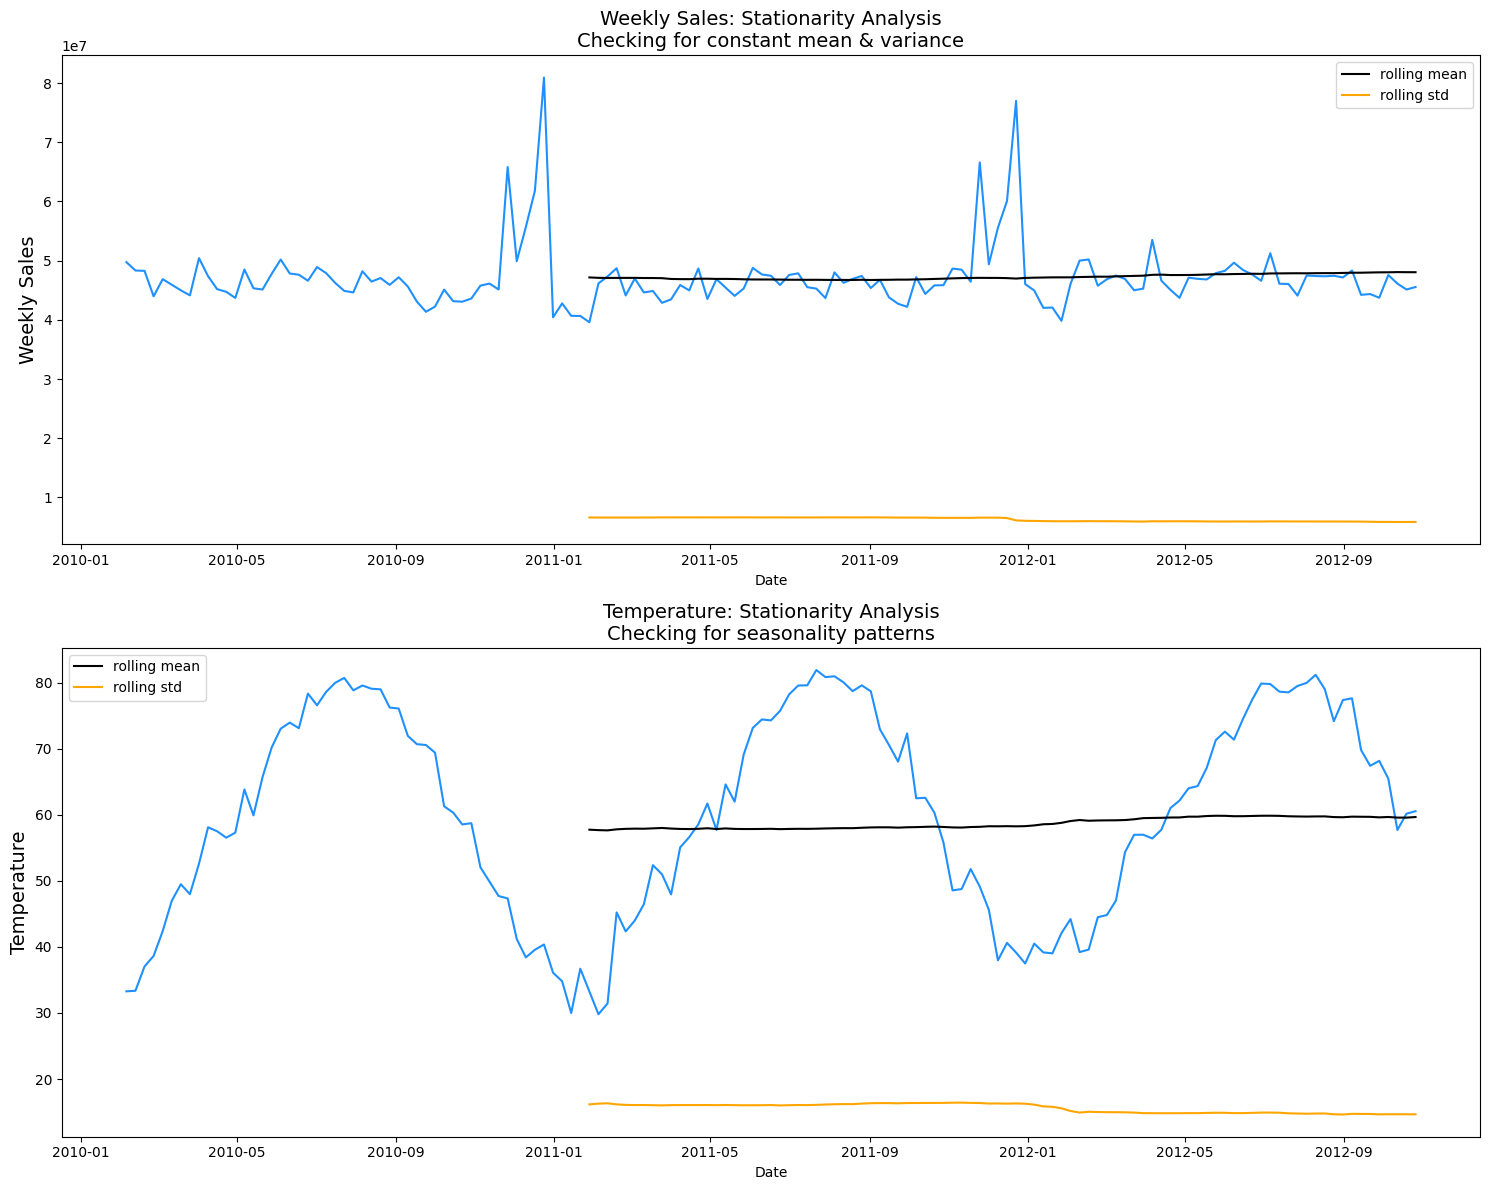

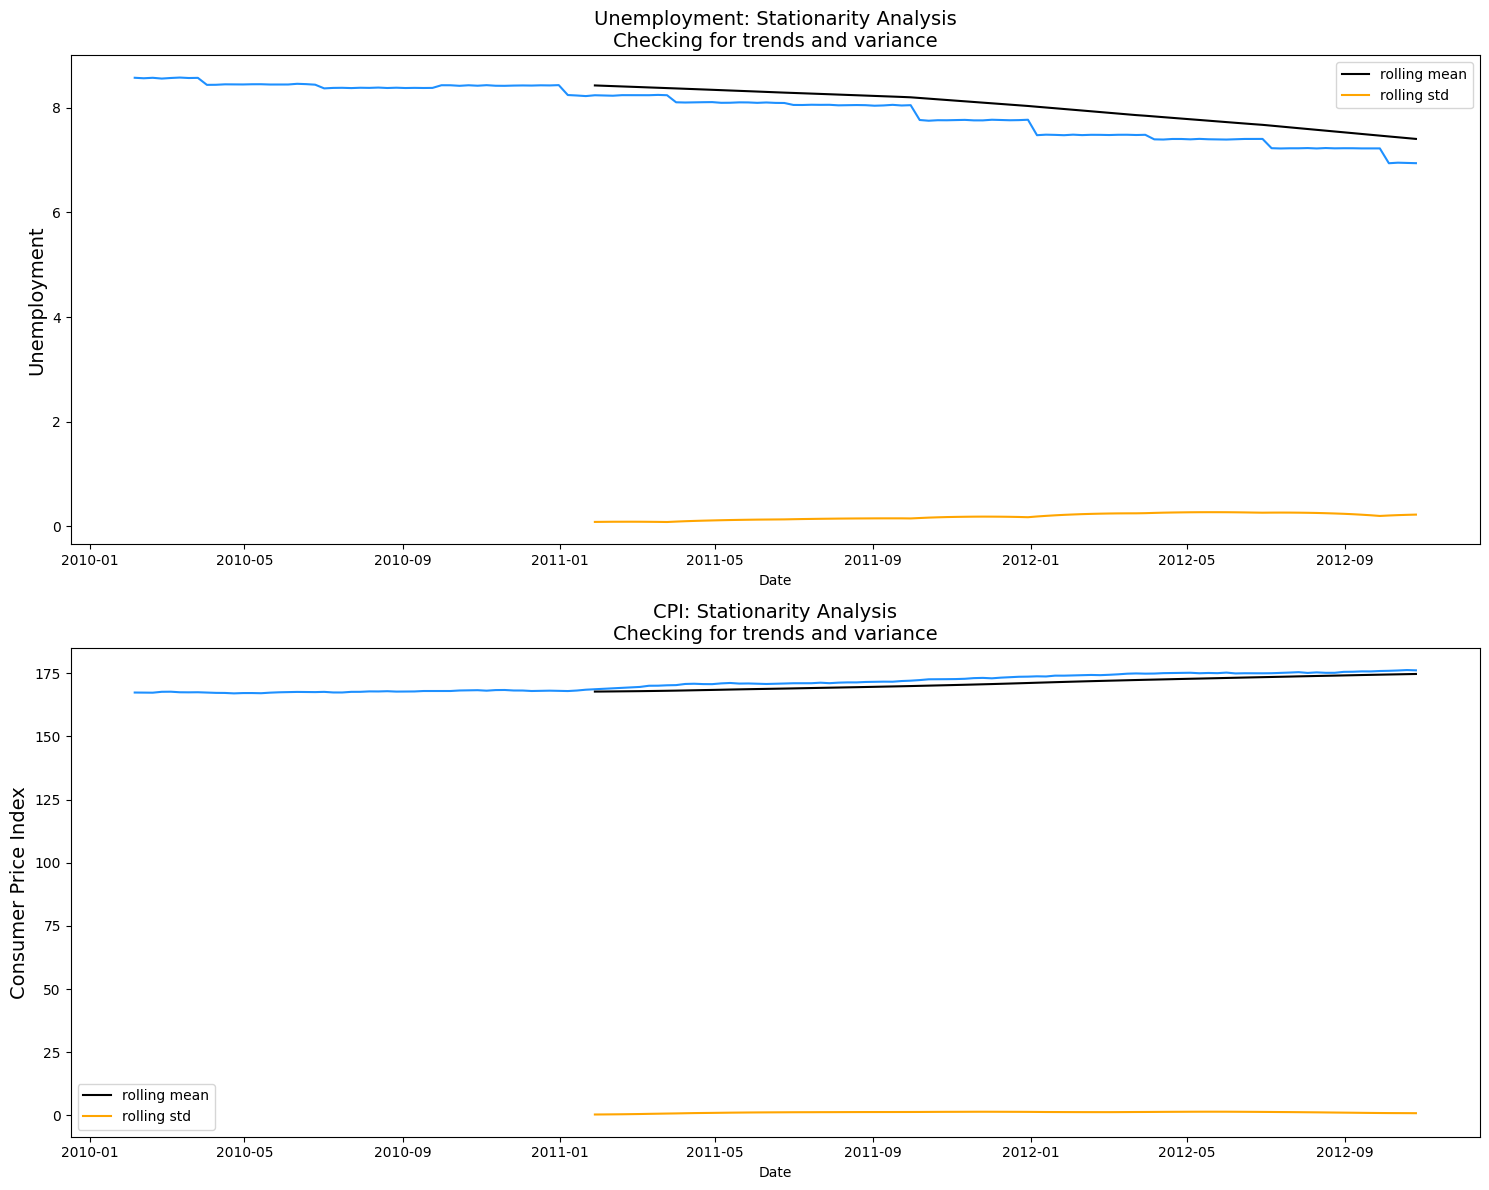

Stationarity Analysis Interpretation:
1. A time series is stationary if it has constant mean and variance over time.
2. If the rolling mean (black line) shows a trend or the rolling standard deviation (orange line) changes significantly over time, the series is not stationary.
3. Non-stationary series may need transformations (differencing, log transformation, etc.) before modeling with methods like ARIMA.


In [ ]:
# Add rolling window analysis for stationarity check
# A year has 52 weeks (52 weeks * 7 days per week) approx.
rolling_window = 52

# Group data by Date for time series analysis
weekly_sales_by_date = data.groupby('Date')['Weekly_Sales'].sum()
temperature_by_date = data.groupby('Date')['Temperature'].mean()

# Create the visualization
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

# Weekly Sales analysis
sns.lineplot(x=weekly_sales_by_date.index, y=weekly_sales_by_date.values, ax=ax[0], color='dodgerblue')
sns.lineplot(x=weekly_sales_by_date.index,
             y=weekly_sales_by_date.rolling(rolling_window).mean(),
             ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=weekly_sales_by_date.index,
             y=weekly_sales_by_date.rolling(rolling_window).std(),
             ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Weekly Sales: Stationarity Analysis\nChecking for constant mean & variance', fontsize=14)
ax[0].set_ylabel(ylabel='Weekly Sales', fontsize=14)
ax[0].legend()

# Temperature analysis
sns.lineplot(x=temperature_by_date.index, y=temperature_by_date.values, ax=ax[1], color='dodgerblue')
sns.lineplot(x=temperature_by_date.index,
             y=temperature_by_date.rolling(rolling_window).mean(),
             ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=temperature_by_date.index,
             y=temperature_by_date.rolling(rolling_window).std(),
             ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Stationarity Analysis\nChecking for seasonality patterns', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].legend()

plt.tight_layout()
plt.show()

# Additional variables that might be of interest
# Let's analyze Unemployment and CPI as well
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

# Unemployment analysis
unemployment_by_date = data.groupby('Date')['Unemployment'].mean()
sns.lineplot(x=unemployment_by_date.index, y=unemployment_by_date.values, ax=ax[0], color='dodgerblue')
sns.lineplot(x=unemployment_by_date.index,
             y=unemployment_by_date.rolling(rolling_window).mean(),
             ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=unemployment_by_date.index,
             y=unemployment_by_date.rolling(rolling_window).std(),
             ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Unemployment: Stationarity Analysis\nChecking for trends and variance', fontsize=14)
ax[0].set_ylabel(ylabel='Unemployment', fontsize=14)
ax[0].legend()

# CPI analysis
cpi_by_date = data.groupby('Date')['CPI'].mean()
sns.lineplot(x=cpi_by_date.index, y=cpi_by_date.values, ax=ax[1], color='dodgerblue')
sns.lineplot(x=cpi_by_date.index,
             y=cpi_by_date.rolling(rolling_window).mean(),
             ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=cpi_by_date.index,
             y=cpi_by_date.rolling(rolling_window).std(),
             ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('CPI: Stationarity Analysis\nChecking for trends and variance', fontsize=14)
ax[1].set_ylabel(ylabel='Consumer Price Index', fontsize=14)
ax[1].legend()

plt.tight_layout()
plt.show()

# Interpret results
print("Stationarity Analysis Interpretation:")
print("1. A time series is stationary if it has constant mean and variance over time.")
print("2. If the rolling mean (black line) shows a trend or the rolling standard deviation (orange line) changes significantly over time, the series is not stationary.")
print("3. Non-stationary series may need transformations (differencing, log transformation, etc.) before modeling with methods like ARIMA.")


Stationarity Test for Weekly Sales:
ADF Statistic: -5.9083
p-value: 0.0000
Critical Values:
	1%: -3.4786
	5%: -2.8827
	10%: -2.5781
Result: The series is stationary (reject H0)


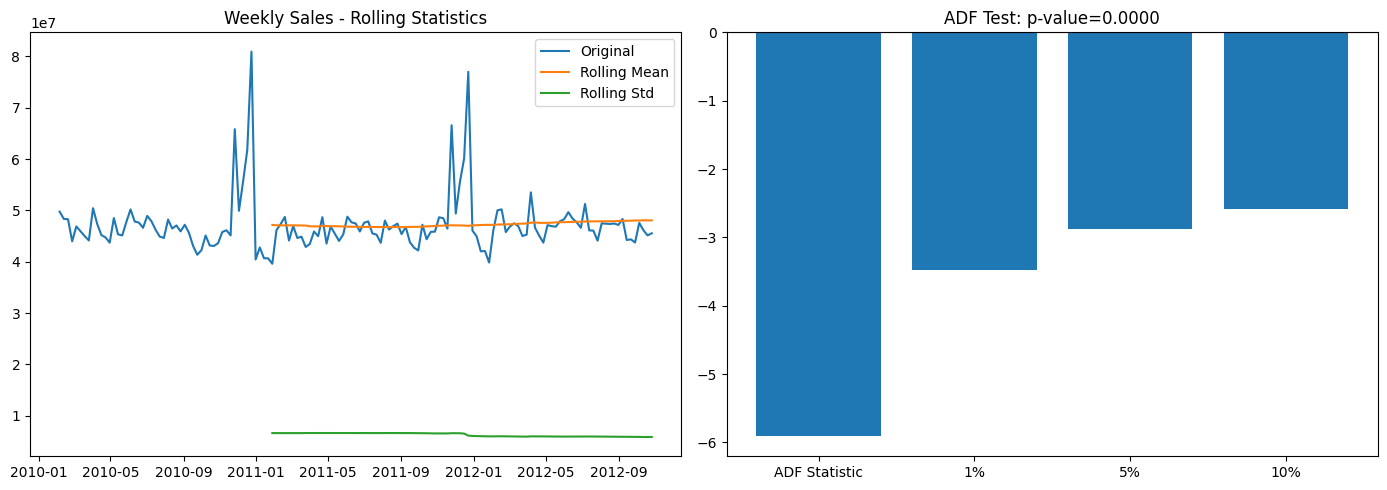

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Group by date for time series analysis
weekly_sales = data.groupby('Date')['Weekly_Sales'].sum()

# Function to check stationarity using Augmented Dickey-Fuller test
def check_stationarity(time_series, title):
    # Plot rolling statistics
    plt.figure(figsize=(14, 5))

    # Original time series
    plt.subplot(1, 2, 1)
    plt.plot(time_series, label='Original')
    plt.plot(time_series.rolling(window=52).mean(), label='Rolling Mean')
    plt.plot(time_series.rolling(window=52).std(), label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'{title} - Rolling Statistics')

    # Augmented Dickey-Fuller test
    result = adfuller(time_series.dropna())

    # Plot results
    plt.subplot(1, 2, 2)
    plt.bar(['ADF Statistic', '1%', '5%', '10%'],
           [result[0], result[4]['1%'], result[4]['5%'], result[4]['10%']])
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(f'ADF Test: p-value={result[1]:.4f}')

    # Print results
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.4f}")

    # Conclude on stationarity
    if result[1] <= 0.05:
        print("Result: The series is stationary (reject H0)")
    else:
        print("Result: The series is not stationary (fail to reject H0)")

    plt.tight_layout()
    plt.show()

# Check stationarity of weekly sales
print("\nStationarity Test for Weekly Sales:")
check_stationarity(weekly_sales, 'Weekly Sales')


Stationarity Test for Differenced Weekly Sales:
ADF Statistic: -6.6995
p-value: 0.0000
Critical Values:
	1%: -3.4801
	5%: -2.8834
	10%: -2.5784
Result: The series is stationary (reject H0)


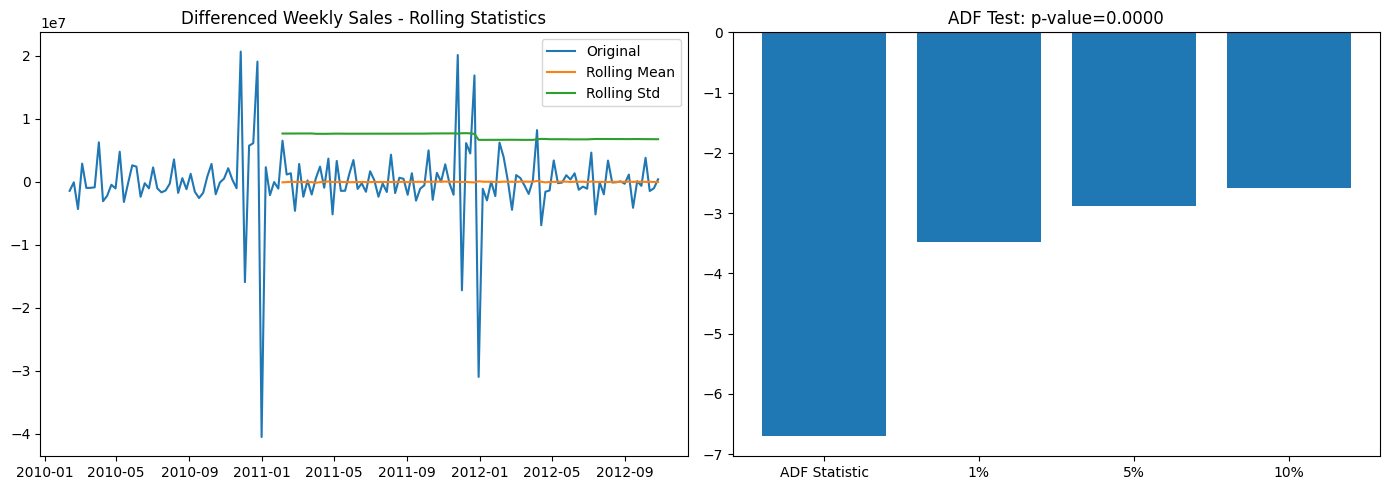

In [ ]:
# Differencing to make series stationary if needed
weekly_sales_diff = weekly_sales.diff().dropna()

print("\nStationarity Test for Differenced Weekly Sales:")
check_stationarity(weekly_sales_diff, 'Differenced Weekly Sales')

# 5. Time Series Decomposition

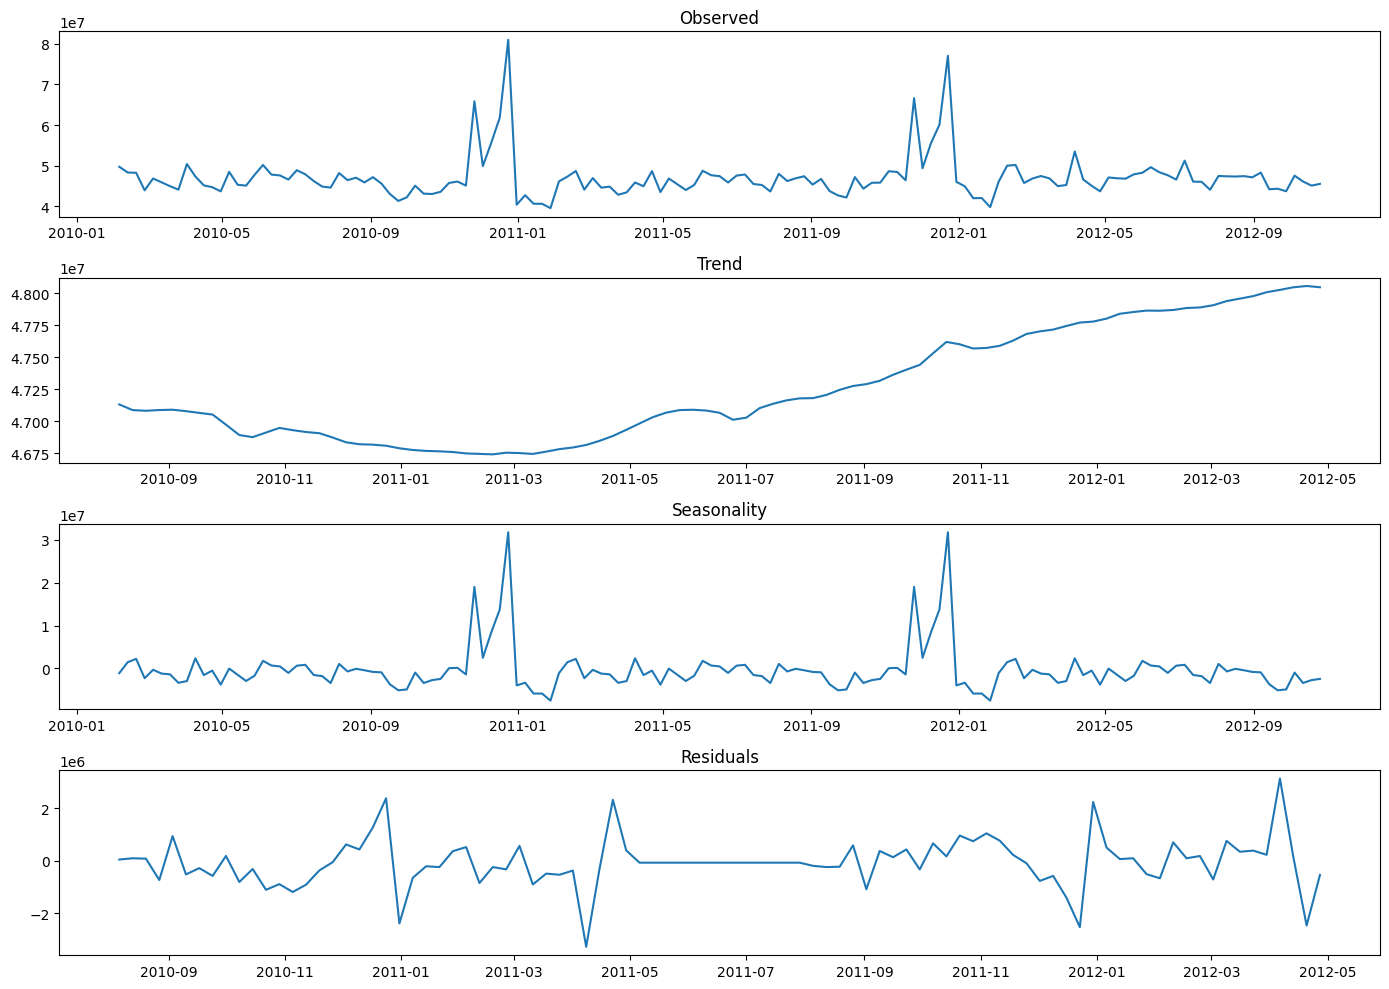

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series Decomposition - extract trend, seasonality, and residuals
plt.figure(figsize=(14, 10))

# Perform decomposition
decomposition = seasonal_decompose(weekly_sales, model='additive', period=52)

# Plot decomposition
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

# 6. Autocorrelation Analysis

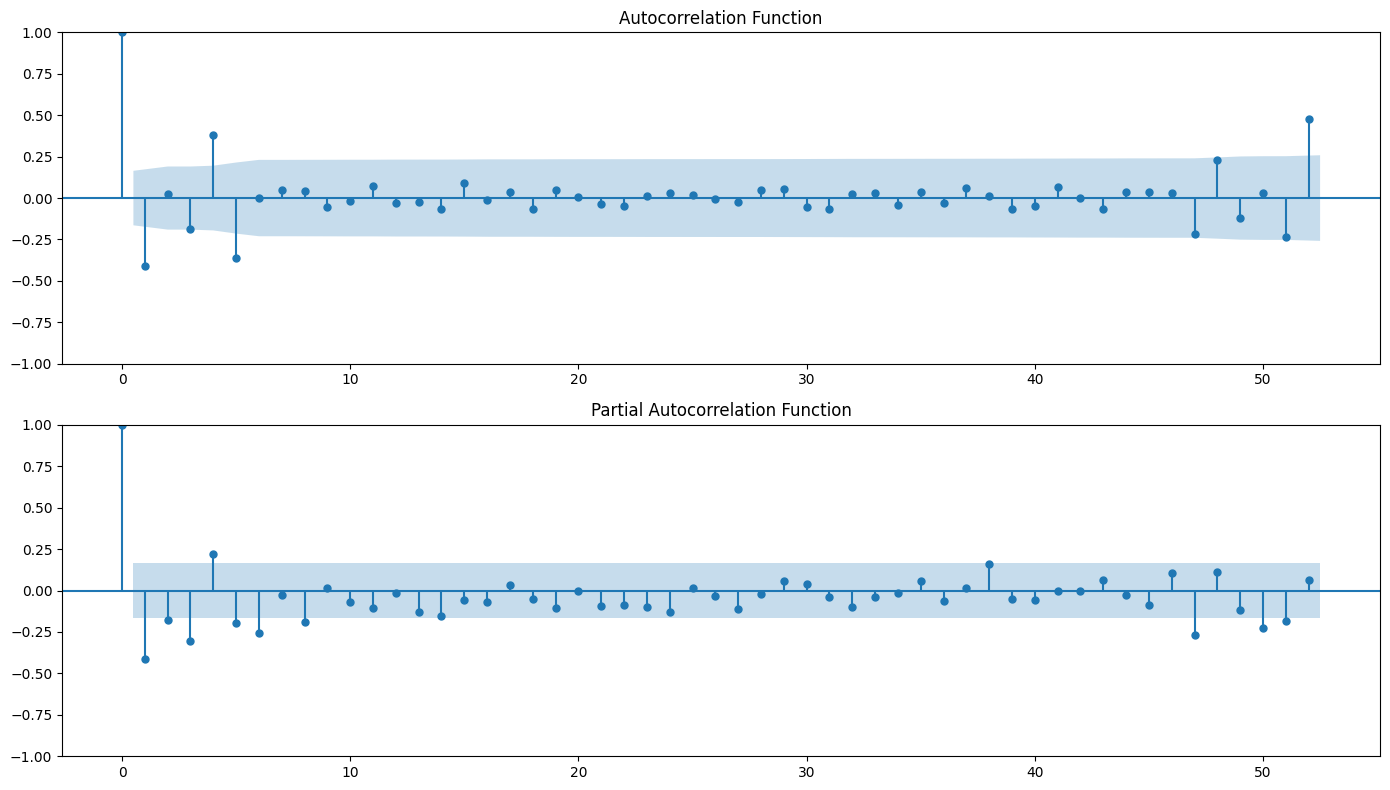

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
plt.figure(figsize=(14, 8))

# ACF plot
plt.subplot(2, 1, 1)
plot_acf(weekly_sales_diff.dropna(), lags=52, ax=plt.gca())
plt.title('Autocorrelation Function')

# PACF plot
plt.subplot(2, 1, 2)
plot_pacf(weekly_sales_diff.dropna(), lags=52, ax=plt.gca())
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

# 7. Advanced Time Series Modeling

In [ ]:
# 80-20 train-test split based on Date
# Get unique dates in the dataset
unique_dates = data["Date"].unique()
train_size = int(len(unique_dates) * 0.85)

# Split dates into training and testing sets
train_dates = unique_dates[:train_size]
test_dates = unique_dates[train_size:]

# Create training and testing dataframes based on the date split
train_data = data[data["Date"].isin(train_dates)]
test_data = data[data["Date"].isin(test_dates)]

In [ ]:
# Checking for stationarity using Augmented Dickey-Fuller (ADF) test

from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, d=0):
    if d > 0:
        for i in range(d):
            series = series.diff().dropna()
    result = adfuller(series)
    print(f'd = {d} | ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}')
    return result[1]

# Try differencing for d = 0, 1, 2
for d in range(3):
    check_stationarity(weekly_sales.copy(), d)


d = 0 | ADF Statistic = -5.9083, p-value = 0.0000
d = 1 | ADF Statistic = -6.6995, p-value = 0.0000
d = 2 | ADF Statistic = -6.9451, p-value = 0.0000


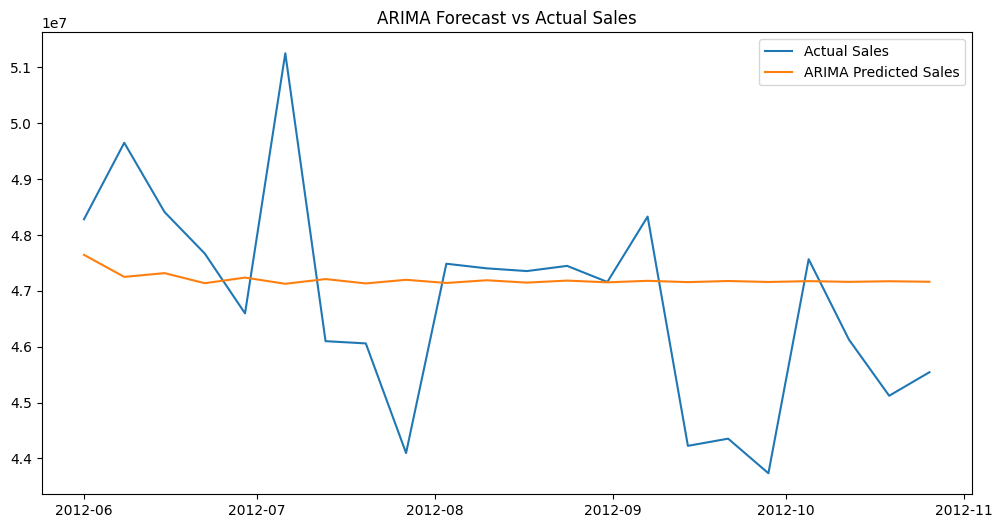

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(train_data.groupby("Date")["Weekly_Sales"].sum(), order=(2, 0, 1))
results_arima = model_arima.fit()

# Forecast on the test data
forecast_steps = len(test_dates)
forecast_arima = results_arima.get_forecast(steps=forecast_steps)
predicted_mean_arima = forecast_arima.predicted_mean

# Align the forecast with the test data's dates
predicted_sales_arima = pd.Series(predicted_mean_arima.values, index=test_dates)

# Evaluate the model on the test data
actual_sales = test_data.groupby("Date")["Weekly_Sales"].sum()

# Plot ARIMA Forecast vs Actual Sales
plt.figure(figsize=(12, 6))
plt.plot(actual_sales, label='Actual Sales')
plt.plot(predicted_sales_arima, label='ARIMA Predicted Sales')  # Changed label
plt.title("ARIMA Forecast vs Actual Sales")
plt.legend()
plt.show()

In [ ]:
def seasonal_D(series, s, D=0):
    if D > 0:
        for _ in range(D):
            series = series.diff(s).dropna()
    result = adfuller(series)
    print(f'D = {D} | ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}')

for D in range(3):
    seasonal_D(weekly_sales.copy(), s=52, D=D)


D = 0 | ADF Statistic = -5.9083, p-value = 0.0000
D = 1 | ADF Statistic = -7.3890, p-value = 0.0000
D = 2 | ADF Statistic = -3.8609, p-value = 0.0023


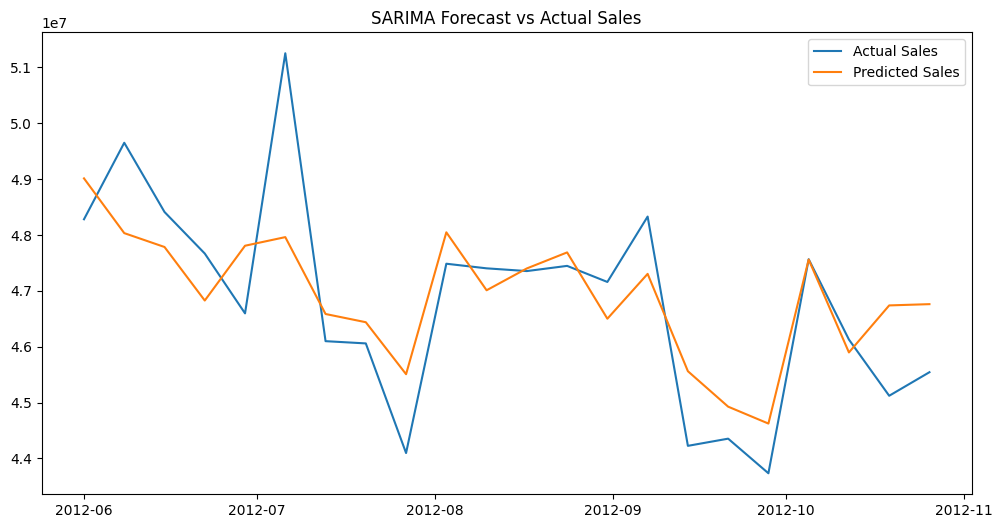

In [ ]:
# Fit SARIMA on the training data
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train_data.groupby("Date")["Weekly_Sales"].sum(),
    order=(2, 0, 1),
    seasonal_order=(2, 0, 1, 52)
)
results = model.fit()

# Forecast on the test data
forecast_steps = len(test_dates) # Use the number of unique test dates
forecast = results.get_forecast(steps=forecast_steps)
predicted_mean = forecast.predicted_mean

# Align the forecast with the test data's dates
predicted_sales = pd.Series(predicted_mean.values, index=test_dates)

# Evaluate the model on the test data
actual_sales = test_data.groupby("Date")["Weekly_Sales"].sum()


#Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_sales, label='Actual Sales')
plt.plot(predicted_sales, label='Predicted Sales')
plt.title("SARIMA Forecast vs Actual Sales")
plt.legend()
plt.show()